## Зачем это нужно

В квантовой химии часто встаёт задача поиска переходного состояня (ПС). Нахождение энергии переходного состояния (а именно разности энергий между минимумом и переходным состоянием) позволяет найти кинетические параметры реакции, такие как скорость. Его можно исать многими методами, и это - один из них. Чем он может быть лучше мнгих других методов? Он не требует расчёта гессиана, который квадратично зависит от числа атомов, только расчёты градиентов, которые линейны. Он является алгоритмом направленного поиска, т.е. пользователь в понятном самому себе виде задаёт направление поиска.

## Как запускать
примеры запуска в README.md, в ./tests много тестов-примеров стуктур и bomds_to_search.
### Структура bonds_to_search
Этот файл описывает то, каким образом в ходе искомой реакции изменяется структура

- charge - заряд структуры
- solvent - растворитель (если без растворителя, то vacuum)
- dof_symb - символ степени свободы, "b" для связи, "a" для угла и "d" для двугранного угла.
- aNum - номер атома (атомы в молекуле считаются с 1, а не с 0). Для связи 2 номера, для угла 3 и для двугранного угла 4.
- change_val коэффициент изменения степени свободы в ходе реакции. Обычно -1 для уменьшения её величины и 1 для увеличения

```
charge
solvent
dof_symb aNum1 aNum2 [aNum3] [aNum4] change_val
dof_symb aNum1 aNum2 [aNum3] [aNum4] change_val
dof_symb aNum1 aNum2 [aNum3] [aNum4] change_val
dof_symb aNum1 aNum2 [aNum3] [aNum4] change_val
...
```

Например, (`./tests/da_test`)

```
0
vacuum
b 1 11 1
b 4 12 1
```

Тут реакция ищется для одновременного увеличения связей 1-11 и 4-12, в вакууме при заряде структуры 0.

## Реализация

Задача поиска ставится так: Нужно найти максимум в выдленном направлении на поверхности потенциальной энергии (ППЭ), найдя по всем ортогональным направлениям минимум. Для этого найдём силовое поле седловой поверхности (здесь y^2-x^2): 



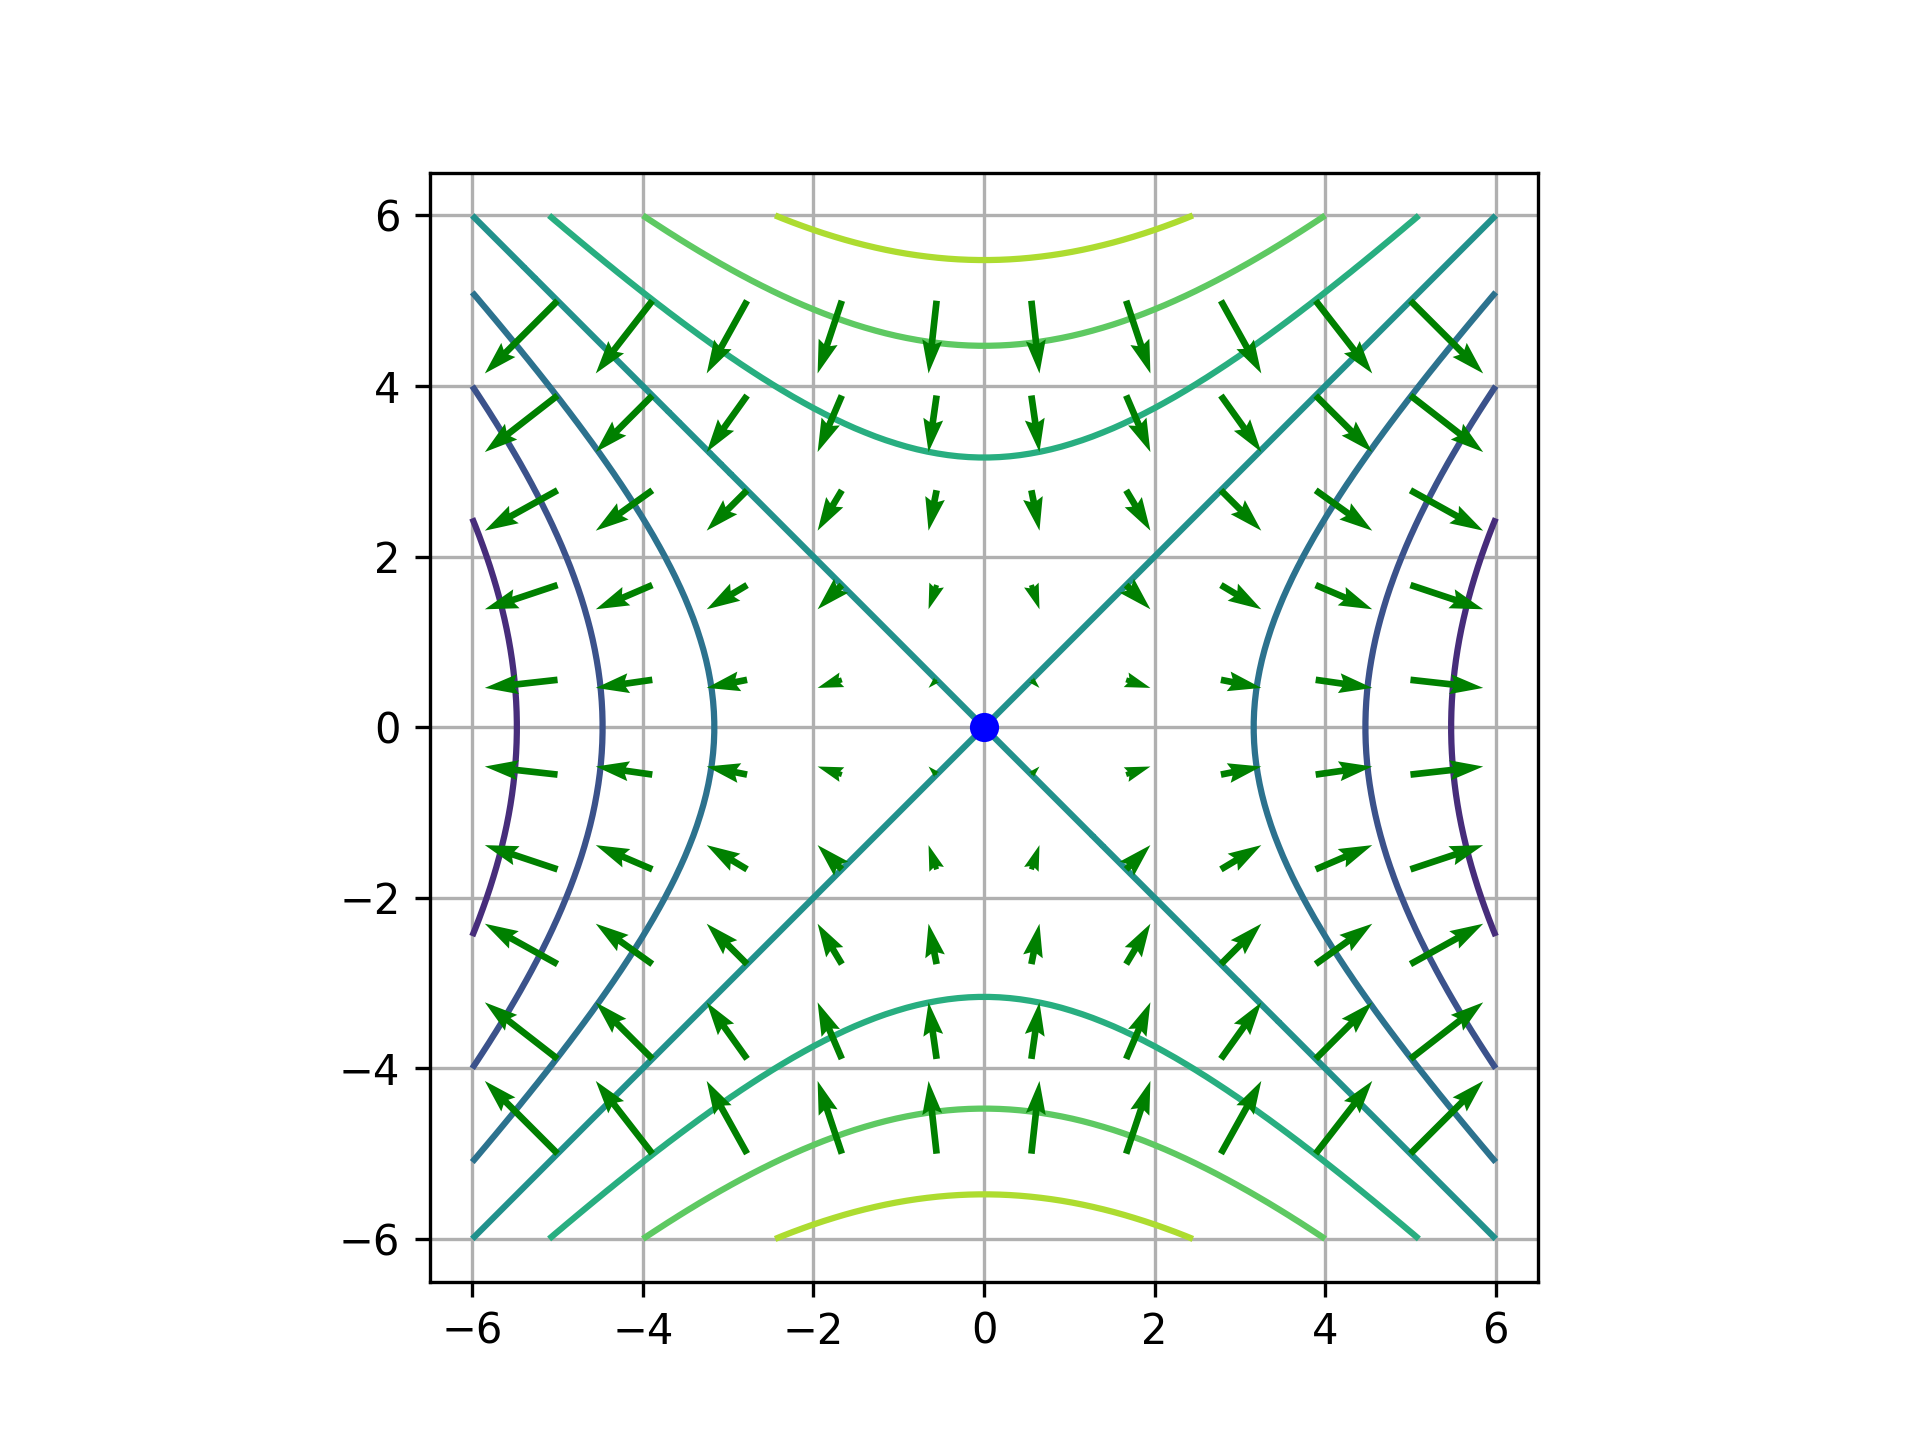

In [1]:
from IPython.display import Image
Image(filename='./pictures/sadd1_ff.png') 

И отразим в направлении поиска (здесь горизонтальная ось, так как реакция - путь, соединяющий минимумы - идёт в горизонтальном направлении). Седловая поверхность превратится в поверхность с минимумом, его найти можно многоими алгоритмами.

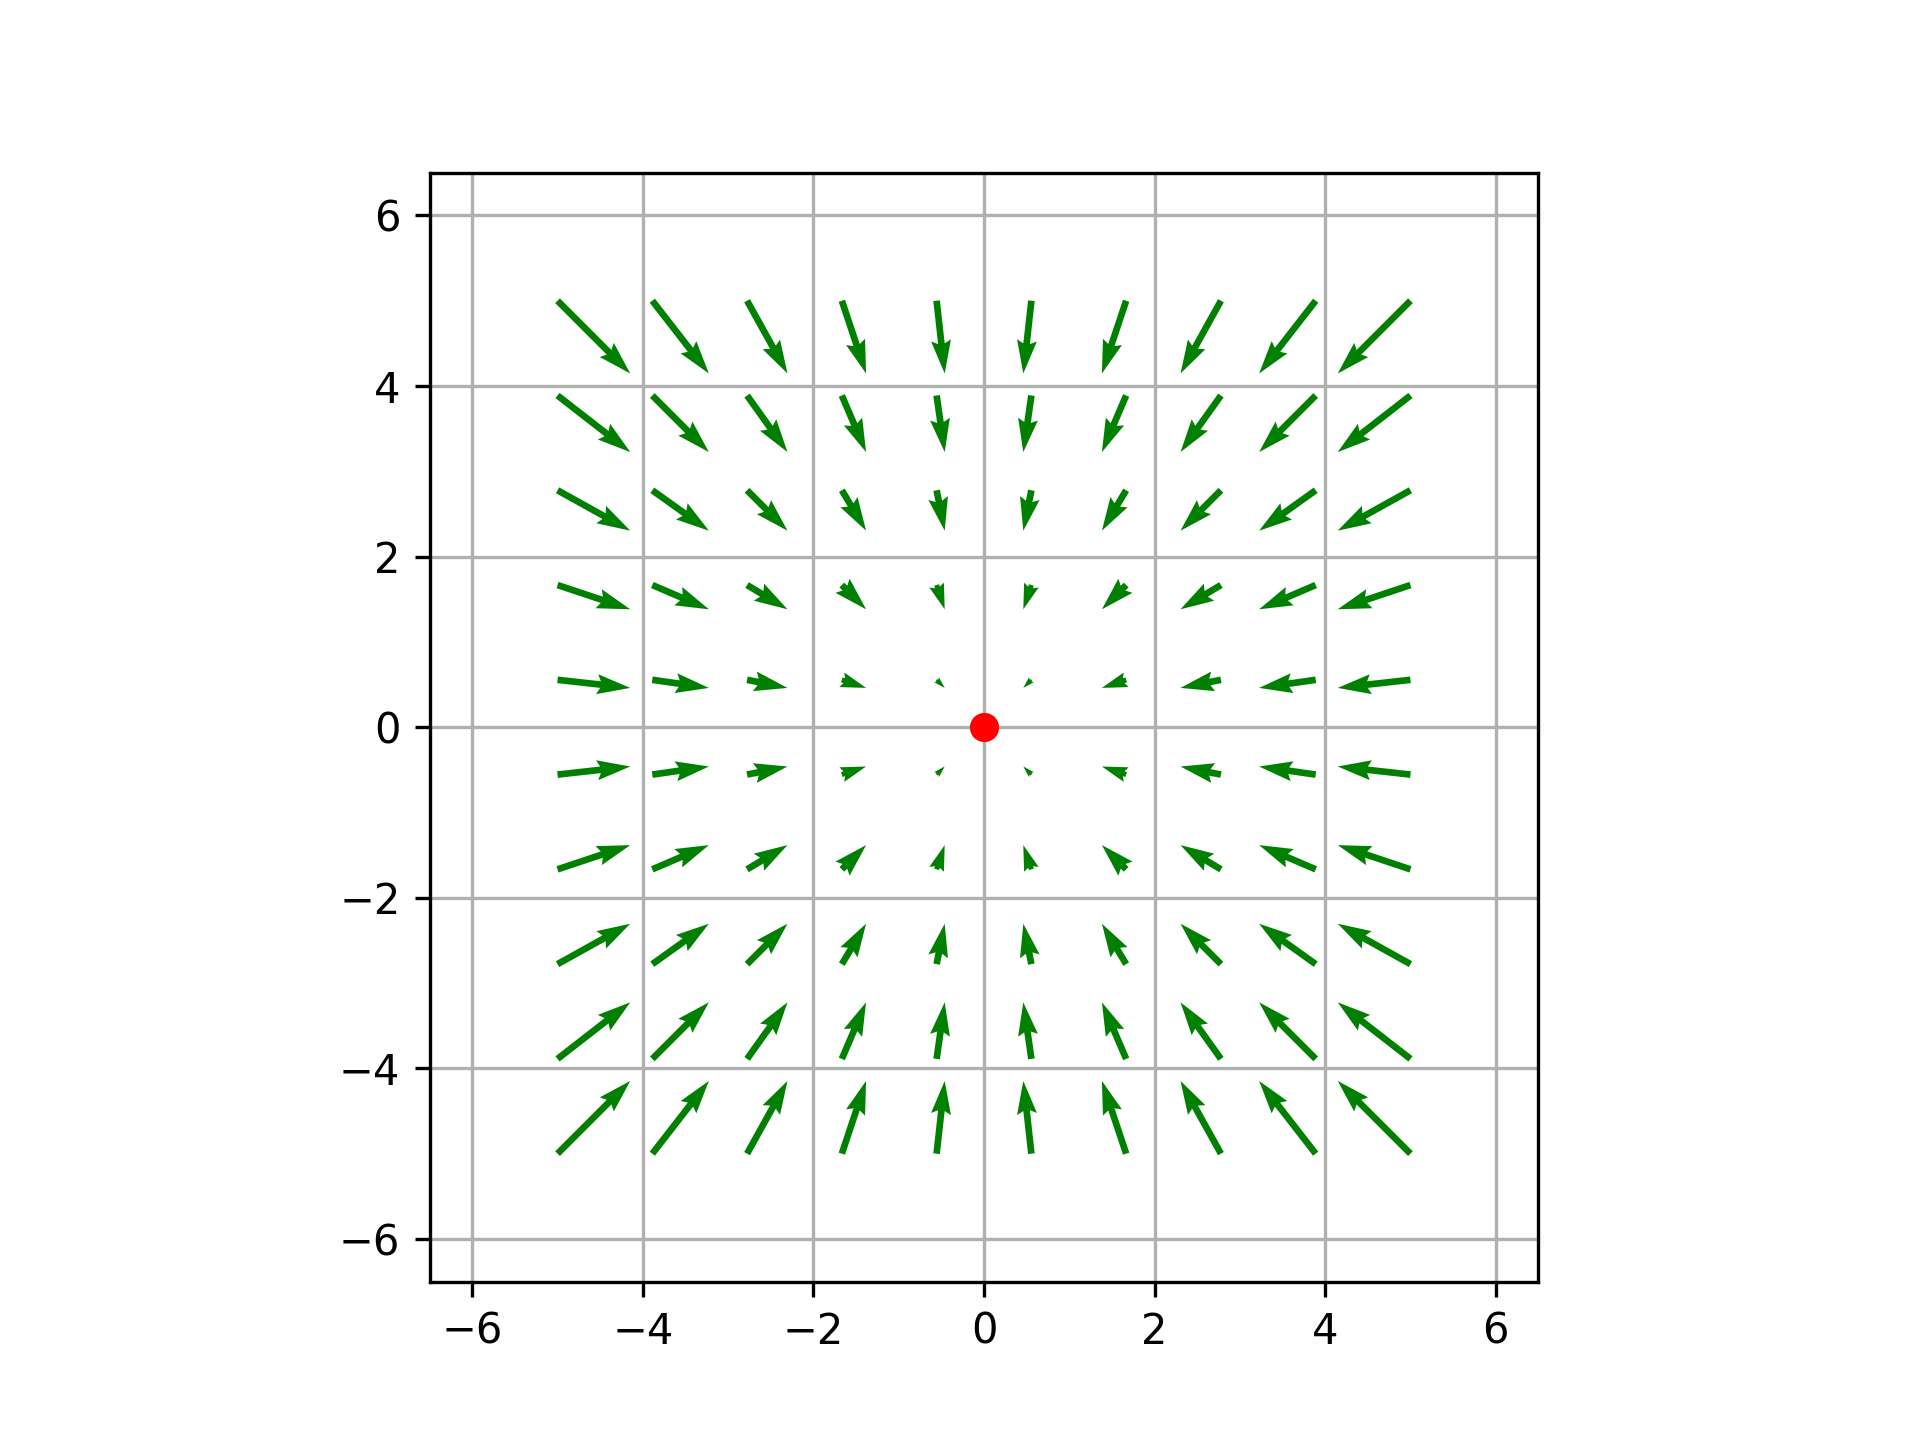

In [2]:
Image(filename='./pictures/sadd1_rev_x_ff.png') 

Здесь нам, в силу выбора поверхности, повезло - полученное поле потенциально (является полем параболоида y^2+x^2). Это не обязательно, например, для слегка повёрнутого гперболоида такое отраажение приводит к силовому полю с фокусом. Но фокус тоже может быть найден алгоритмами оптимизации. 

Не подходит хорошо показывающий себя в поиске минимума BFGS - ему нужен потенциал, а тут поле может быть вообще не потенциальным. Но подходит градиентный спуск или ADAM. Реализация ADAM из pytorch не подходит, потому что ей требуется функция, по которой и вычисляются градиенты, поэтому был написан вариант, которому требуется только производная (как и есть в оригинальном описании ADAM)

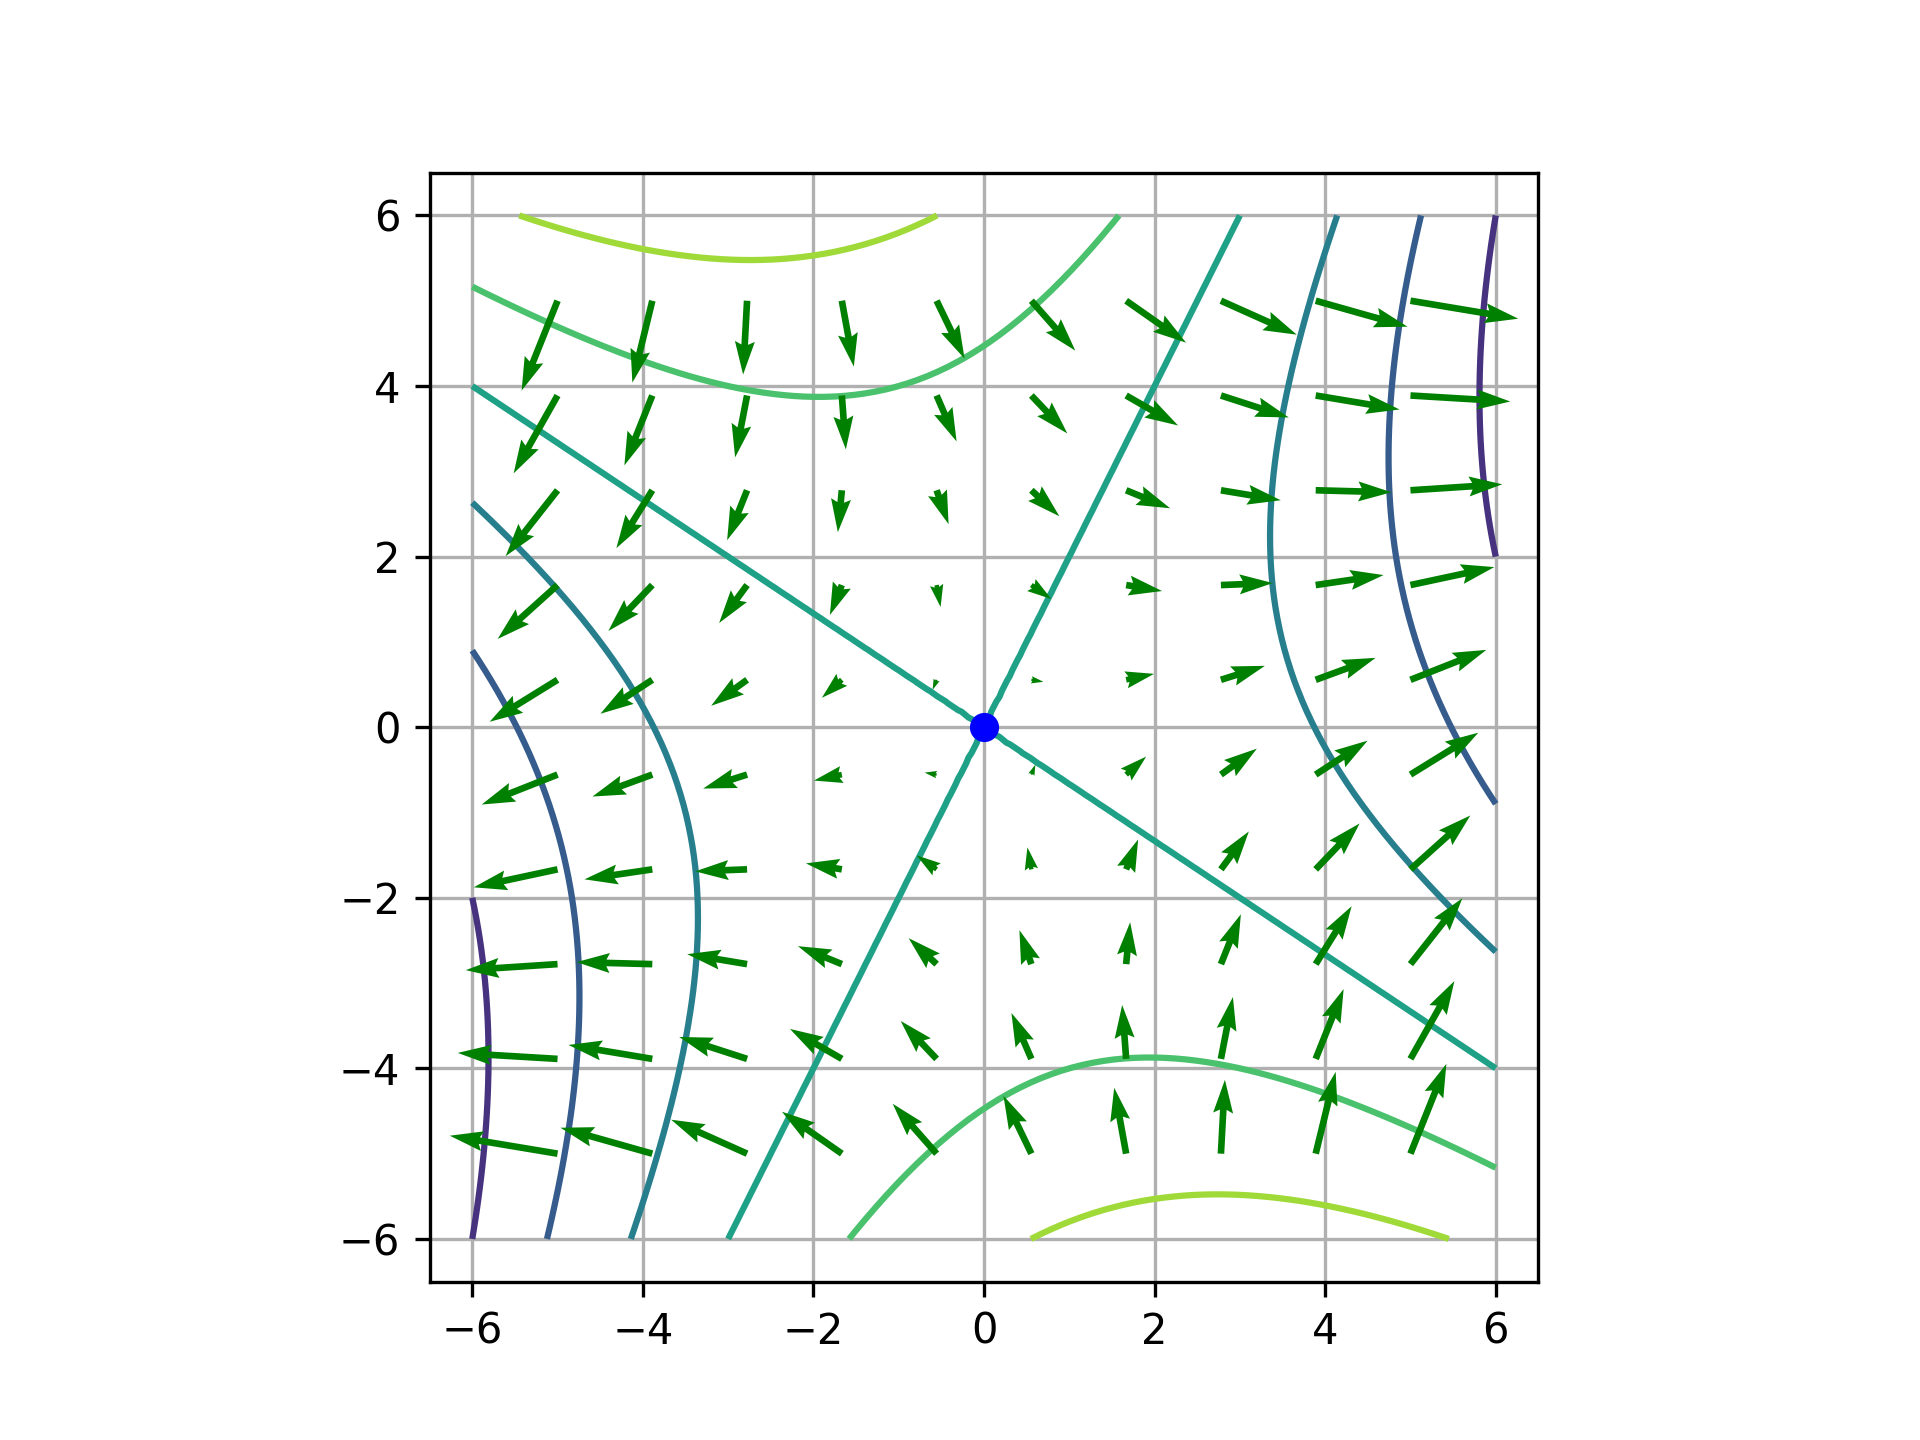

In [9]:
i1=Image(filename='./pictures/sadd2_ff.png') #неотражённая
i2=Image(filename='./pictures/sadd2_rev_x_ff.png') #отражённая
i1


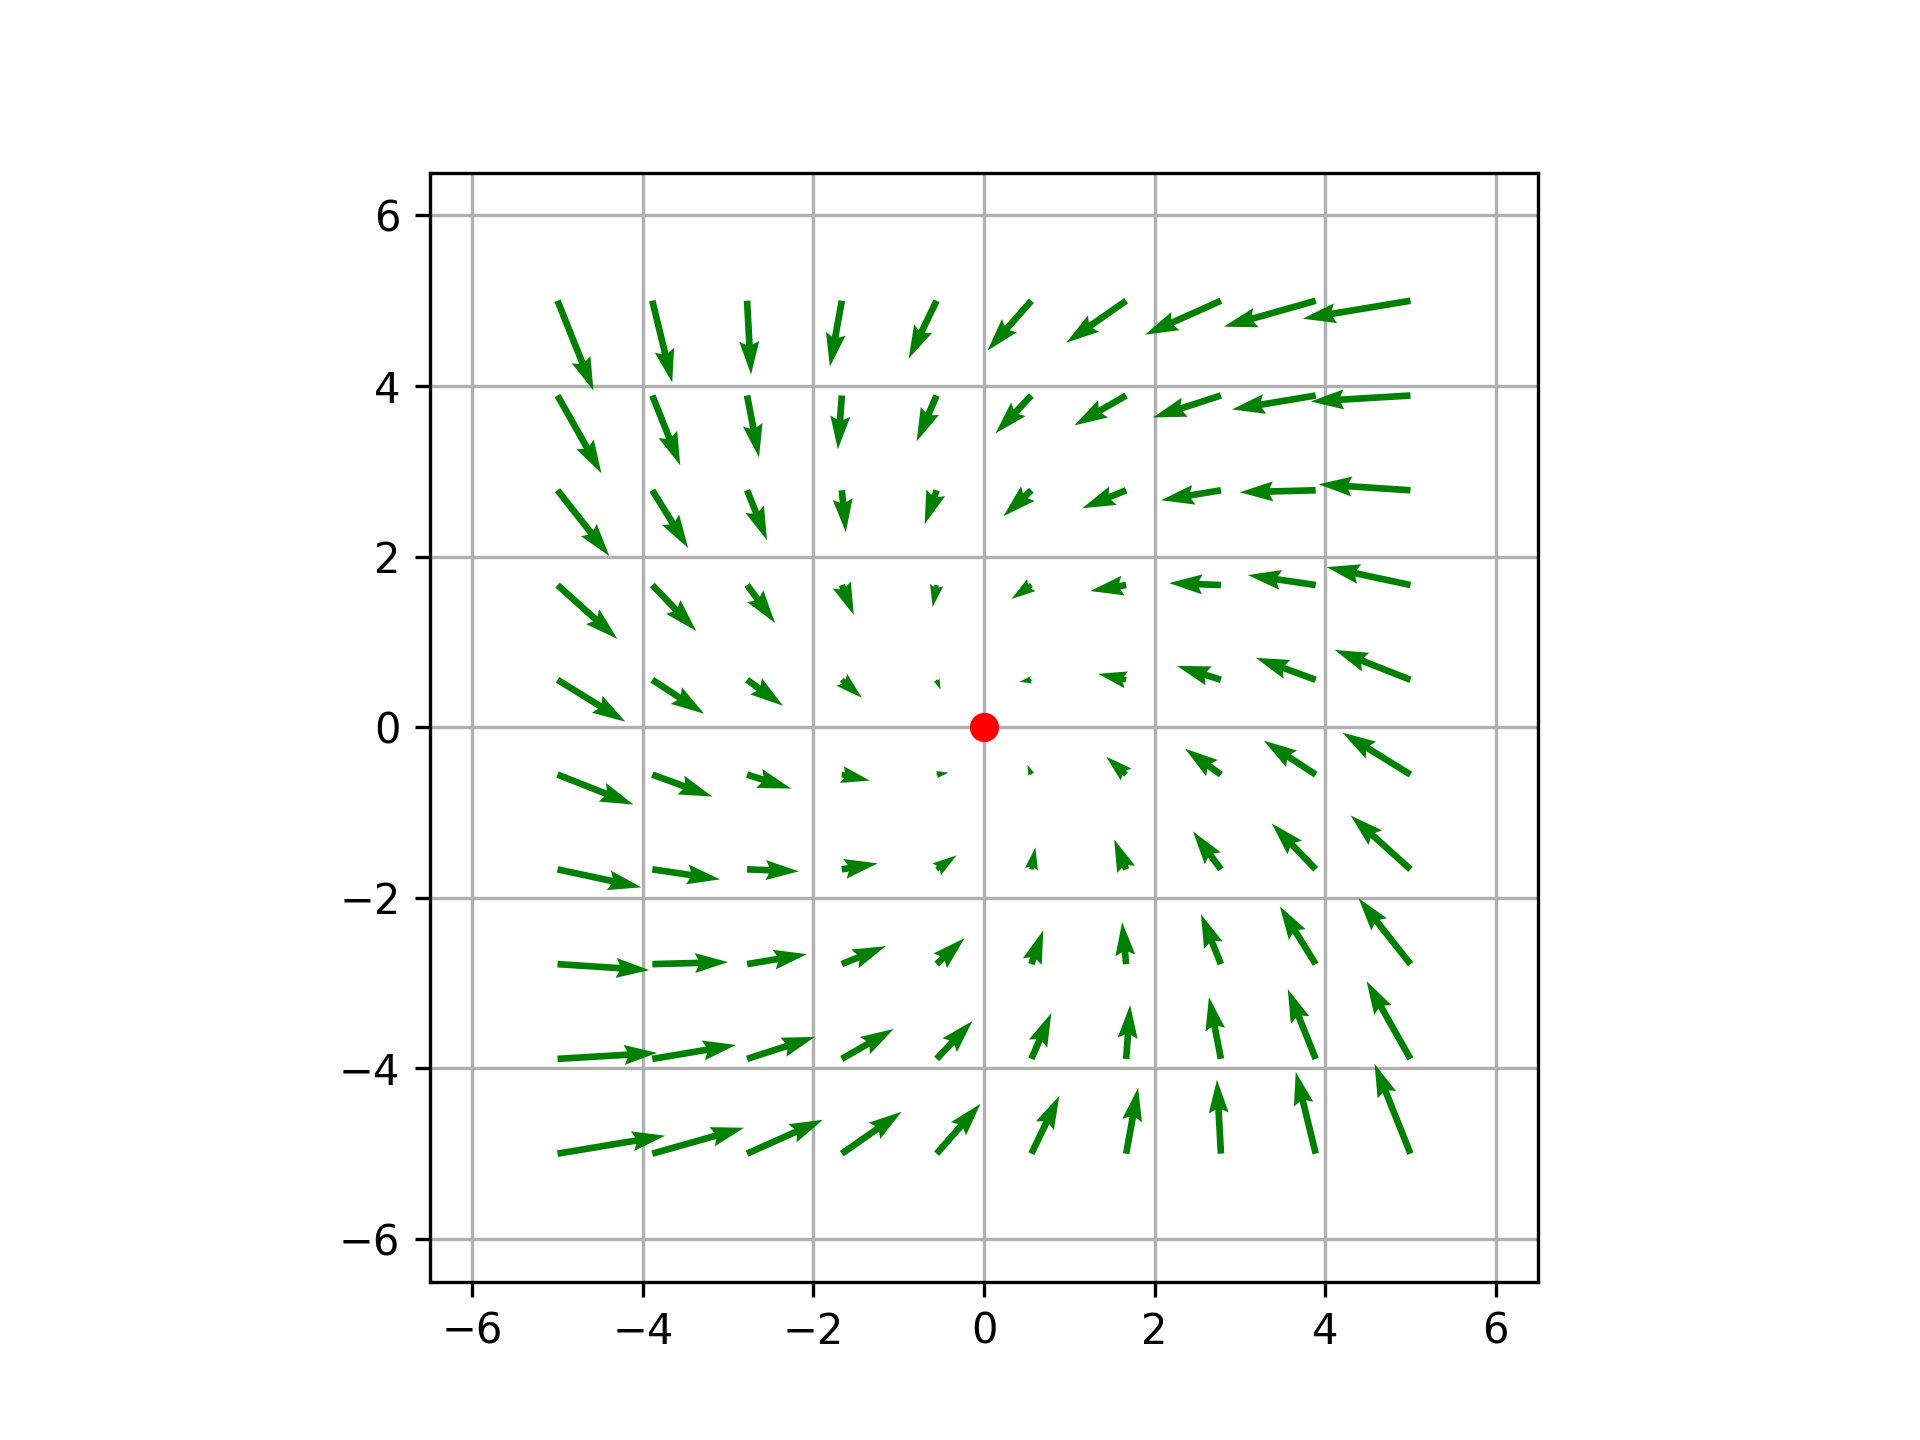

In [8]:
i2

Здесь реализуется поиск переходных состояний для ППЭ вида :-cos(3*0.31415*x) - cos(3*0.31415*y) в различных направлениях (16 стартовых точек (чёрные кружки) и 16 совпадающх с направлением точки от центра направлений поиска)
Подобным образом это происходит в файле ./pictures/optim_example.py, только тут картинка рисуется, а не сохраняется в файл

[]

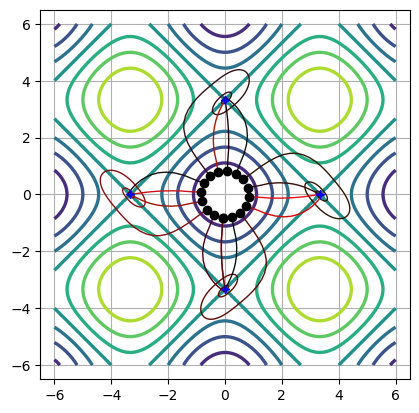

In [10]:
import numpy as np

import matplotlib.pyplot as plt
import random,copy 
e=2.718281828
func= lambda x,y :-np.cos(3*0.31415*x) - np.cos(3*0.31415*y)
class optim():
    def __init__(self,entry_x,entry_y,vf_x,vf_y,func):
        self.grad=np.zeros((2))
        self.xy=np.array([float(entry_x),float(entry_y)])
        self.phase_vec=np.array([vf_x,vf_y])
        self.func=func
        self.coef_grad=0.1
        self.step=0
        self.prev_maxgrad=1e100

        self.vk=np.zeros((2))
        self.Gk=0
        

    def mirror(self):
        mul_res=np.sum(self.phase_vec*self.grad)
        sqr_res=np.sum(self.phase_vec*self.phase_vec)
        mirror_grad_cos=min(1,abs(mul_res/(sqr_res*np.sum(self.grad*self.grad))**0.5)/5)
        #print( f"pre-mirr_g cos {abs(mul_res/(sqr_res*np.sum(self.grad*self.grad))**0.5)}")
        #print (f"mirrorgrad cos {mirror_grad_cos}")
        self.grad=np.subtract(self.grad,(1+mirror_grad_cos)*np.multiply(mul_res/sqr_res,self.phase_vec))
    
    def get_grad(self):
        dx=lambda x,y,f:(-f(x-0.001,y)+f(x+0.001,y))/0.002
        dy=lambda x,y,f:(-f(x,y-0.001)+f(x,y+0.001))/0.002
        grad=np.array([dx(self.xy[0],self.xy[1],self.func),dy(self.xy[0],self.xy[1],self.func)])
        return grad, max(abs(grad))
    
    def apply_grad(self):    
        self.xy-=self.grad*self.coef_grad
    
    def proceed(self):
        self.xs=[self.xy[0]]
        self.ys=[self.xy[1]]
        while(self.move_DoFs()>0.001):
            #print(f"step {self.step} ({self.xy[0]}, {self.xy[1]})")
            self.xs.append(self.xy[0])
            self.ys.append(self.xy[1])
            #input()
            if self.step>=100000:
                break
        self.get_grad()

        self.mirror()

        return self.xs,self.ys
  
    def move_DoFs(self):
        b1=0.2
        b2=0.99
        eps=1e-8
        #TRUST_RAD=0.1

        self.grad, maxgrad=self.get_grad()
        self.g=copy.deepcopy(self.grad)
        self.mirror()
        self.d_mirror=self.g-self.grad

        #if(maxgrad*self.coef_grad>TRUST_RAD):
        #    self.coef_grad=TRUST_RAD/maxgrad
            
        if self.step>20 or 1:
            #ADAM
            self.vk = b1*self.vk + (1-b1)*self.grad#*self.coef_grad
            self.Gk = b2*self.Gk + (1-b2)*np.sum(self.grad*self.grad)#*self.coef_grad**2
            self.xy=self.xy-5e-2*(self.Gk+eps)**(-0.5) * self.vk
            
            self.get_grad()
            
        else:#GD - потому что первые 20 происходит значительная смена параметров, и нечего давать её в инерционный алгоритм
            self.grad_true=copy.deepcopy(self.grad)

            self.apply_grad()
            self.get_grad()
            self.grad=self.grad_true

        self.prev_d_mirror=self.d_mirror
        self.prev_grad=copy.deepcopy(self.grad)

        self.step+=1

        
        #print(f"coef grad {self.coef_grad}")
        self.prev_maxgrad=maxgrad
        return maxgrad

def frange(x, y, jump):
  n=0
  while x+n*jump < y:
    yield x+n*jump
    n+=1

plt.axes().set_aspect(1)  
plt.grid(zorder=0)

xc, yc = np.meshgrid(np.linspace(-6, 6, 100),  
                   np.linspace(-6, 6, 100)) 
plt.contour(xc, yc, func(xc,yc),linewidths=2.4,zorder=2) 


J_MIN=-5
J_MAX=5
I_MIN=-5
I_MAX=5

I_MIN=-3.1415+3.1415/32
I_MAX=3.1415

for i in frange (I_MIN,I_MAX+0.1,3.1415*2/16):
    trace=optim(np.sin(i)/1.2,np.cos(i)/1.2,np.sin(i),np.cos(i),func)#search direction is same as vector
    xs,ys=trace.proceed()

    #color_tuple=(((i-I_MIN)/(I_MAX-I_MIN))**2/2+0.5,(1-((j-J_MIN)/(J_MAX-J_MIN)+(j-J_MIN)/(J_MAX-J_MIN))/2)**2,((j-J_MIN)/(J_MAX-J_MIN))**2)
    color_tuple=(random.random(),random.random()/10,random.random()/10)
    plt.plot(xs, ys,color=color_tuple,linewidth=1,zorder=2*(3+(i-I_MIN)))
    plt.scatter([xs[0]], [ys[0]],color="black",linewidth=1,zorder=2*(3+(i-I_MIN))*2)
    plt.scatter([xs[-1]], [ys[-1]],color="b",marker="+",linewidth=1,zorder=2*(3+(i-I_MIN)*2+1))
    trace=0

plt.xlim(-6.5, 6.5) 
plt.ylim(-6.5, 6.5) 

plt.plot()

### О желаемом и действительном: formHuman и formAlg:
Это всё очень хорошо, но для молекулы хочется описания реакции не в виде "атом 3 увеличивает x координату сохраняя y и z, атом 17 уменьшает z"=formAlg, а в виде "связь между 3 и 4 укорачивается, угол между 4,6 и 7 увеличивается"=formHuman (см. любой bonds_to_search в ./tests) - это гораздо более интуитивно понятные величины в молекуле, и их использование позволит сильно снизить трудозатраты при использовании алгоритма. Значит, нужно научиться получать formAlg из formHuman.

### Как происходит получение formAlg из formHuman:
Каждая участвующая в реакции степень свободы - связь, угол, двугранный угол представляется как функция от текущих координат своих атомов. Затем от неё берутся производные в значении получения вектора градиента этой функции от своих координат. Для ускорения они берутся в наиболее интересных направлениях, а для связи оцениваются полностью аналитически. 

- Для связи производная всегда равна 1 по модулю и направление увеличения связи проходит вдоль связи для каждого атома.
- Для угла производные по направлениям, перпендикулярным плоскости угла точно равны 0. При этом, производные вдоль плеч угла для крайних атомов тоже равну нулю. Значит для крайних достаточно взять производную в направлении, лежащем в плоскости угла и перпендикулярном соответствующей стороне угла. Для центрального равна нулю производная, направленная по описанной окружности угла (ведь величина дуги равна двум велчинам стягиваемого ей угла, а дуга не изменяется при движении вершины угла по окружности).
`./angle_3d_rev.py`

- Для двугранного угла для крайних атомов справедливо то же, что и для обычного, но "центральным атомом" здесь является ось угла, а плоскостью угла, соответственно, перпендикулярная оси плоскость; а для центральных берутся честные численные производные по 3 координатам.
`./dihedral_3d_rev.py`

На самом деле, все эти производные можно оценить аналитически, но это даст небольшой прирост скорости, ведь большую часть времени считется квантовая химия, а не отражения градиента

Затем все эти полученные вкторы складываются с коэффициентами, указанными в bonds_to_search (те самые -1 для укорачивающейся и 1 для удлинняющейся степени свободы, которые не обязаны быть 1 по модулю), а потом  на тех атомах, на которых в результате такого суммирования получились ненулевые вектора отражения выполняется нормировка вектора на 1 (этот шаг по непонятным мне причинам сильно улучшает сходимость в нужную - к ПС - сторону).

После чего вектор градиента системы (как 3N вектор, составленный из градиентов каждого атома) отражается по направлению вектора отражения. Под отражением понимается формула g = g-v*(1+f)*(v,g)/(v,v), g - градиент, v - вектор отражения, f - коэффициент отражения, зависящий от косинуса между v и g, чтобы, если v перпендикулярно g не проискодило попыток движения вдоль реакционной координаты, а если v и g совпадают по направлению, то это говорит о том, что точка находится на реакционном пуи и движение в сторону возрастания силы точно будет движением в сторону ПС.

<b>NOTE:</b> Данный текст можно рассматривать как поясение работы `./mirror_fn.py`

Ну и, наконец, добавляя возможность считать в xtb и orca, добавляя печать и ввод трешхолдов, чтение геометрий из файлов, логгинг структур, предоптимизацию (начальное расслабление структуры по степеням свободы, не участвующим в реакции), "расшевеливая" атомы при помощи strange_constant, чтобы структура не рвалась (более подробное описание в коментариях к ней в `./TS_find_mirror.py`), получаем OptTS:

In [12]:
from TS_find_mirror import optTS
import os
optTS(xyz_path=os.path.join(os.getcwd(),"tests","da_test", "to_opt.xyz"), threshold_rel=8, threshold_force=0.0001, mirror_coef=0.4, print_output=True, maxstep=10**4, programm=dict(name="xtb", force_constant= 6, acc=0.01),do_preopt=True,step_along=0)

reading inputs

/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz
2
[0.70710678 0.70710678]
{(1, 11): 2.043272053095238, (4, 12): 2.4060590210960306}
lens is clear
(2.043272053095238, 0, array([0.70710678, 0.70710678]))
2.043272053095238
(2.4060590210960306, 1, array([0.70710678, 0.70710678]))
2.4060590210960306


normal termination of xtb
normal termination of xtb
normal termination of xtb
normal termination of xtb


/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 0
0.9719946978331694
mgcos 0.19439893956663387
strangeC 0.2584553863309669
1e+101
force    trashold       0.0128412 of       0.0001000: not converged
relative trashold       7.0526179 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 1
0.8092556443592187
mgcos 0.16185112887184375
strangeC 0.15451355306351983
0.012841212519425552
force    trashold       0.0093524 of       0.0001000: not converged
relative trashold       1.3382275 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 2
0.20257465943711236
mgcos 0.04051493188742247
strangeC 0.15212808599228342


normal termination of xtb
normal termination of xtb
normal termination of xtb
normal termination of xtb


force    trashold       0.0247860 of       0.0001000: not converged
relative trashold       5.8695182 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 3
0.38793082498925197
mgcos 0.0775861649978504
strangeC 0.13984212547754984
force    trashold       0.0150651 of       0.0001000: not converged
relative trashold       3.5473082 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 4
0.3302372727342
mgcos 0.06604745454684
strangeC 0.19222161760138454
force    trashold       0.0163308 of       0.0001000: not converged
relative trashold       5.5009541 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 5
0.3748942103788565
mgcos 0.0749788420757713
strangeC 0.16302949529293284
force    trashold       0.0117047 of       0.0001000: not converged
relative trashold       4.0100

normal termination of xtb
normal termination of xtb
normal termination of xtb
normal termination of xtb


force    trashold       0.0108217 of       0.0001000: not converged
relative trashold       4.4094906 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 7
0.44268654573950095
mgcos 0.08853730914790019
strangeC 0.1906470519571109
0.009352448292447475
force    trashold       0.0089450 of       0.0001000: not converged
relative trashold       4.7141462 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 8
0.5855475329046296
mgcos 0.11710950658092592
strangeC 0.1375782759010506
0.008945001372705073
force    trashold       0.0061556 of       0.0001000: not converged
relative trashold       3.2237756 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 9
0.4720533057768571
mgcos 0.09441066115537142
strangeC 0.22805572567475269
force    trashold       0.0071090 of       0.00010

normal termination of xtb
normal termination of xtb
normal termination of xtb
normal termination of xtb


0.0061555742831674335
force    trashold       0.0048194 of       0.0001000: not converged
relative trashold       4.1890112 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 11
0.5984414006552499
mgcos 0.11968828013104997
strangeC 0.16766670587421
force    trashold       0.0049562 of       0.0001000: not converged
relative trashold       4.7523914 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 12
0.6371402692969045
mgcos 0.12742805385938089
strangeC 0.1526569328670959
0.004819445917469274
force    trashold       0.0048122 of       0.0001000: not converged
relative trashold       6.2925537 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 13
0.7607132838431745
mgcos 0.1521426567686349
strangeC 0.10761886917475919
0.004812247584531847
force    trashold       0.003

normal termination of xtb
normal termination of xtb
normal termination of xtb
normal termination of xtb


force    trashold       0.0036276 of       0.0001000: not converged
relative trashold       5.5137125 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 15
0.7872827695895255
mgcos 0.15745655391790508
strangeC 0.08644099921959826
0.003460014184115105
force    trashold       0.0030325 of       0.0001000: not converged
relative trashold       5.0655862 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 16
0.743604812260704
mgcos 0.14872096245214078
strangeC 0.1001127812631005
0.0030324708400180206
force    trashold       0.0028336 of       0.0001000: not converged
relative trashold       6.5226082 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 17
0.8004361403927756
mgcos 0.1600872280785551
strangeC 0.1178085766390658
0.002833573577808407
force    trashold       0.00

normal termination of xtb
normal termination of xtb
normal termination of xtb
normal termination of xtb


0.002666910346240456
force    trashold       0.0025318 of       0.0001000: not converged
relative trashold       5.4022586 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 19
0.8160528604601672
mgcos 0.16321057209203343
strangeC 0.10232537039958776
0.0025318031395238296
force    trashold       0.0021564 of       0.0001000: not converged
relative trashold       4.4180289 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 20
0.790297594382508
mgcos 0.1580595188765016
strangeC 0.12306579946030367
0.0021563945739070133
force    trashold       0.0020268 of       0.0001000: not converged
relative trashold       5.1001483 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 21
0.8225915864117554
mgcos 0.16451831728235108
strangeC 0.06989844516610698
0.0020267977368596344
for

normal termination of xtb
normal termination of xtb
normal termination of xtb
normal termination of xtb


force    trashold       0.0018566 of       0.0001000: not converged
relative trashold       5.1972639 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 23
0.8037654371835103
mgcos 0.16075308743670208
strangeC 0.08982171560465126
0.001854914509117506
force    trashold       0.0016618 of       0.0001000: not converged
relative trashold       4.3606805 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 24
0.7849512829055169
mgcos 0.15699025658110338
strangeC 0.09034437323588607
0.0016617844661118363
force    trashold       0.0014863 of       0.0001000: not converged
relative trashold       4.1269878 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 25
0.777976527990474
mgcos 0.1555953055980948
strangeC 0.09932059862525586
0.0014863076710116458
force    trashold       0

normal termination of xtb
normal termination of xtb
normal termination of xtb
normal termination of xtb


0.0013673050671430373
force    trashold       0.0013407 of       0.0001000: not converged
relative trashold       4.3534385 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 27
0.7504315423115784
mgcos 0.1500863084623157
strangeC 0.08173832030658641
0.0013406962506913509
force    trashold       0.0012801 of       0.0001000: not converged
relative trashold       4.1567288 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 28
0.7376166096144906
mgcos 0.14752332192289813
strangeC 0.08387099651917117
0.0012801348456508038
force    trashold       0.0011793 of       0.0001000: not converged
relative trashold       3.8400460 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 29
0.7196506680651356
mgcos 0.14393013361302712
strangeC 0.08348247109681008
0.0011792627771336193
f

normal termination of xtb
normal termination of xtb
normal termination of xtb
normal termination of xtb


0.0010740793367662448
force    trashold       0.0010223 of       0.0001000: not converged
relative trashold       3.5562847 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 31
0.682082758039592
mgcos 0.13641655160791838
strangeC 0.1056364906284951
0.0010223319959895272
force    trashold       0.0009758 of       0.0001000: not converged
relative trashold       3.5352757 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 32
0.663691189063601
mgcos 0.1327382378127202
strangeC 0.09341554830188276
0.0009757851737806902
force    trashold       0.0009340 of       0.0001000: not converged
relative trashold       3.4650966 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 33
0.6462134698702833
mgcos 0.12924269397405666
strangeC 0.08371753653527479
0.0009340466226461999
forc

normal termination of xtb
normal termination of xtb
normal termination of xtb
normal termination of xtb


0.00086782182217984
force    trashold       0.0008062 of       0.0001000: not converged
relative trashold       3.0546636 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 35
0.601299470770974
mgcos 0.1202598941541948
strangeC 0.09922423846806723
0.0008062426322341847
force    trashold       0.0007542 of       0.0001000: not converged
relative trashold       2.9354516 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 36
0.5837497933654757
mgcos 0.11674995867309515
strangeC 0.0993414699390121
0.0007542478031008174
force    trashold       0.0007189 of       0.0001000: not converged
relative trashold       2.8942805 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 37
0.566251625766178
mgcos 0.1132503251532356
strangeC 0.09099201290689783
0.0007189325468856573
force  

normal termination of xtb
normal termination of xtb
normal termination of xtb
normal termination of xtb


0.0006878942975668054
force    trashold       0.0006506 of       0.0001000: not converged
relative trashold       2.7115167 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 39
0.5247763218057218
mgcos 0.10495526436114436
strangeC 0.09480087413447293
0.0006505849694511751
force    trashold       0.0006089 of       0.0001000: not converged
relative trashold       2.5802600 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 40
0.5072404291784935
mgcos 0.10144808583569871
strangeC 0.09571842480219626
0.0006089203124252937
force    trashold       0.0005764 of       0.0001000: not converged
relative trashold       2.5074440 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 41
0.49235304467343816
mgcos 0.09847060893468763
strangeC 0.09052903977276779
0.0005763576989384667

normal termination of xtb
normal termination of xtb
normal termination of xtb
normal termination of xtb


0.0005529912365222512
force    trashold       0.0005318 of       0.0001000: not converged
relative trashold       2.4214479 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 43
0.4602692213001188
mgcos 0.09205384426002376
strangeC 0.08745151038841108
0.0005318454492801377
force    trashold       0.0005061 of       0.0001000: not converged
relative trashold       2.3423690 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 44
0.44463227909549996
mgcos 0.0889264558191
strangeC 0.08942273590203735
0.0005060698344062129
force    trashold       0.0004810 of       0.0001000: not converged
relative trashold       2.2732029 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 45
0.4314007606587487
mgcos 0.08628015213174975
strangeC 0.08859284435595917
0.0004809979241547875
for

normal termination of xtb
normal termination of xtb
normal termination of xtb
normal termination of xtb


0.00046068038665276264
force    trashold       0.0004444 of       0.0001000: not converged
relative trashold       2.1993918 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 47
0.40832360651660854
mgcos 0.08166472130332171
strangeC 0.08312498706360703
0.00044442264527453626
force    trashold       0.0004285 of       0.0001000: not converged
relative trashold       2.1624811 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 48
0.39688986026115186
mgcos 0.07937797205223038
strangeC 0.08317570488174625
0.00042847035574518995
force    trashold       0.0004118 of       0.0001000: not converged
relative trashold       2.1191012 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 49
0.38623181654218625
mgcos 0.07724636330843725
strangeC 0.08357248257178591
0.00041177802331

normal termination of xtb
normal termination of xtb
normal termination of xtb
normal termination of xtb
normal termination of xtb


0.000395559944783854
force    trashold       0.0003813 of       0.0001000: not converged
relative trashold       2.0477734 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 51
0.36927789821011786
mgcos 0.07385557964202358
strangeC 0.08107630682640941
0.00038128177383897204
force    trashold       0.0003690 of       0.0001000: not converged
relative trashold       2.0247561 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 52
0.36165828060132926
mgcos 0.07233165612026585
strangeC 0.08045952271685806
0.0003690232154970224
force    trashold       0.0003576 of       0.0001000: not converged
relative trashold       2.0027374 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 53
0.3542200909877977
mgcos 0.07084401819755955
strangeC 0.0805438720343253
0.0003576433435779153

normal termination of xtb
normal termination of xtb
normal termination of xtb
normal termination of xtb
normal termination of xtb


0.0003343639442202563
force    trashold       0.0003240 of       0.0001000: not converged
relative trashold       1.9299189 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 56
0.33724884702771096
mgcos 0.06744976940554219
strangeC 0.0785832218009576
0.0003239944105803288
force    trashold       0.0003150 of       0.0001000: not converged
relative trashold       1.9158338 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 57
0.33248214792843367
mgcos 0.06649642958568673
strangeC 0.07865710111870969
0.00031497298364984344
force    trashold       0.0003063 of       0.0001000: not converged
relative trashold       1.9010040 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 58
0.32814563930832463
mgcos 0.06562912786166493
strangeC 0.07854355978930115
0.00030626195905615

normal termination of xtb
normal termination of xtb
normal termination of xtb
normal termination of xtb
normal termination of xtb


0.00028879855469710205
force    trashold       0.0002811 of       0.0001000: not converged
relative trashold       1.8560606 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 61
0.31836134201636446
mgcos 0.06367226840327289
strangeC 0.07762906519263964
0.00028105615676313466
force    trashold       0.0002738 of       0.0001000: not converged
relative trashold       1.8457279 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 62
0.31567731624205586
mgcos 0.06313546324841117
strangeC 0.07771265803474074
0.0002738257219889896
force    trashold       0.0002667 of       0.0001000: not converged
relative trashold       1.8348606 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 63
0.3133434503681253
mgcos 0.06266869007362505
strangeC 0.07777682925028627
0.0002667169619234

normal termination of xtb
normal termination of xtb
normal termination of xtb
normal termination of xtb
normal termination of xtb


0.0002531096875148752
force    trashold       0.0002468 of       0.0001000: not converged
relative trashold       1.8058456 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 66
0.3078374224295458
mgcos 0.061567484485909166
strangeC 0.07856780088613528
0.0002467916348549764
force    trashold       0.0002407 of       0.0001000: not converged
relative trashold       1.7978432 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 67
0.30638098243383244
mgcos 0.061276196486766486
strangeC 0.07897746909307712
0.00024072862902829934
force    trashold       0.0002348 of       0.0001000: not converged
relative trashold       1.7900140 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 68
0.3050660629673359
mgcos 0.06101321259346718
strangeC 0.0792464489599934
0.00023484597552796

normal termination of xtb
normal termination of xtb
normal termination of xtb
normal termination of xtb
normal termination of xtb


0.00022352841882363492
force    trashold       0.0002182 of       0.0001000: not converged
relative trashold       1.7674691 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 71
0.3018491573289635
mgcos 0.0603698314657927
strangeC 0.08026466911151539
0.0002181623275483244
force    trashold       0.0002130 of       0.0001000: not converged
relative trashold       1.7606238 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 72
0.300930488512264
mgcos 0.0601860977024528
strangeC 0.08059483611587585
0.00021297945185646045
force    trashold       0.0002079 of       0.0001000: not converged
relative trashold       1.7536060 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 73
0.3000648959317784
mgcos 0.060012979186355675
strangeC 0.0808709668699031
0.0002079107290264044
f

normal termination of xtb
normal termination of xtb
normal termination of xtb
normal termination of xtb
normal termination of xtb


0.0001981310471604272
force    trashold       0.0001935 of       0.0001000: not converged
relative trashold       1.7325789 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 76
0.2976992770860868
mgcos 0.05953985541721736
strangeC 0.08201319994005998
0.00019345996811594003
force    trashold       0.0001889 of       0.0001000: not converged
relative trashold       1.7256354 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 77
0.29693129145257097
mgcos 0.05938625829051419
strangeC 0.08236918922683721
0.00018890550784641334
force    trashold       0.0001844 of       0.0001000: not converged
relative trashold       1.7185330 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 78
0.296166054787144
mgcos 0.0592332109574288
strangeC 0.0827607779149329
0.00018444936039421233

normal termination of xtb
normal termination of xtb
normal termination of xtb
normal termination of xtb


0.0001758457047900597
force    trashold       0.0001717 of       0.0001000: not converged
relative trashold       1.6964494 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 81
0.29375132323805686
mgcos 0.05875026464761137
strangeC 0.08549988654422687
0.00017170674255059424
force    trashold       0.0001677 of       0.0001000: not converged
relative trashold       1.6888895 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 82
0.29289340702075917
mgcos 0.05857868140415183
strangeC 0.08661242086322347
0.0001676585082965387
force    trashold       0.0001637 of       0.0001000: not converged
relative trashold       1.6810149 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 83
0.2919948611127059
mgcos 0.05839897222254118
strangeC 0.08775388726412926
0.00016368725584651

normal termination of xtb
normal termination of xtb
normal termination of xtb
normal termination of xtb


0.0001602958545888235
force    trashold       0.0001582 of       0.0001000: not converged
relative trashold       1.6877391 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 85
0.29008072797377527
mgcos 0.058016145594755056
strangeC 0.0901235748329025
0.00015816248201699568
force    trashold       0.0001561 of       0.0001000: not converged
relative trashold       1.6973610 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 86
0.28905467184293504
mgcos 0.05781093436858701
strangeC 0.09131029901355073
0.0001560698363126024
force    trashold       0.0001540 of       0.0001000: not converged
relative trashold       1.7069564 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 87
0.2879767455970043
mgcos 0.05759534911940086
strangeC 0.09251232373083224
0.00015401343813010

normal termination of xtb
normal termination of xtb
normal termination of xtb


0.0001519905627713002
force    trashold       0.0001500 of       0.0001000: not converged
relative trashold       1.7259446 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 89
0.28567306952903
mgcos 0.057134613905806
strangeC 0.09493014129999411
0.00014999992742400126
force    trashold       0.0001480 of       0.0001000: not converged
relative trashold       1.7353024 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 90
0.2844414829725501
mgcos 0.05688829659451002
strangeC 0.09613801645683427
0.0001480400949399432
force    trashold       0.0001461 of       0.0001000: not converged
relative trashold       1.7445635 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 91
0.283154886455747
mgcos 0.056630977291149395
strangeC 0.09736569250884035


normal termination of xtb
normal termination of xtb
normal termination of xtb


0.00014610943511606843
force    trashold       0.0001442 of       0.0001000: not converged
relative trashold       1.7537048 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 92
0.28181515478157887
mgcos 0.05636303095631577
strangeC 0.09859654616966002
0.00014420743245402364
force    trashold       0.0001423 of       0.0001000: not converged
relative trashold       1.7627334 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 93
0.2804226974178691
mgcos 0.05608453948357382
strangeC 0.09982637377480533
0.000142334741421853
force    trashold       0.0001405 of       0.0001000: not converged
relative trashold       1.7716664 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 94
0.2789770138342227
mgcos 0.05579540276684454
strangeC 0.10106844821870656


normal termination of xtb
normal termination of xtb
normal termination of xtb
normal termination of xtb


0.00014049178220871248
force    trashold       0.0001387 of       0.0001000: not converged
relative trashold       1.7804876 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 95
0.2774785053824464
mgcos 0.05549570107648928
strangeC 0.1023151501500433
0.00013867821961233428
force    trashold       0.0001369 of       0.0001000: not converged
relative trashold       1.7891825 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 96
0.27592882264852725
mgcos 0.05518576452970545
strangeC 0.10355500945006821
0.00013689370335411474
force    trashold       0.0001351 of       0.0001000: not converged
relative trashold       1.7977559 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 97
0.27432965946474325
mgcos 0.05486593189294865
strangeC 0.10479205472383274
0.0001351381135441

normal termination of xtb
normal termination of xtb
normal termination of xtb
normal termination of xtb


0.00013341103505235352
force    trashold       0.0001317 of       0.0001000: not converged
relative trashold       1.8144918 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 99
0.270986951311242
mgcos 0.0541973902622484
strangeC 0.10724346470290869
0.00013171159620232567
force    trashold       0.0001300 of       0.0001000: not converged
relative trashold       1.8226247 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 100
0.26924691752909713
mgcos 0.05384938350581943
strangeC 0.10845150223083813
0.0001300388519892352
force    trashold       0.0001284 of       0.0001000: not converged
relative trashold       1.8305833 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 101
0.2674639240237411
mgcos 0.053492784804748214
strangeC 0.10964578965896084
0.0001283920631300

normal termination of xtb
normal termination of xtb
normal termination of xtb
normal termination of xtb


0.00012677060470640757
force    trashold       0.0001252 of       0.0001000: not converged
relative trashold       1.8459305 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 103
0.2637769112731456
mgcos 0.05275538225462913
strangeC 0.1119786143203666
0.00012517379154983652
force    trashold       0.0001236 of       0.0001000: not converged
relative trashold       1.8532966 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 104
0.26187773648049045
mgcos 0.05237554729609809
strangeC 0.11311255611783574
0.0001236009587822124
force    trashold       0.0001221 of       0.0001000: not converged
relative trashold       1.8604399 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 105
0.2599446423368519
mgcos 0.051988928467370375
strangeC 0.11421911640451095
0.00012205162581

normal termination of xtb
normal termination of xtb
normal termination of xtb
normal termination of xtb


0.00012052540826862312
force    trashold       0.0001190 of       0.0001000: not converged
relative trashold       1.8739968 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 107
0.2559977761655679
mgcos 0.05119955523311358
strangeC 0.11628600129331979
0.00011902187055501531
force    trashold       0.0001175 of       0.0001000: not converged
relative trashold       1.8804773 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 108
0.25398928266882487
mgcos 0.05079785653376497
strangeC 0.11741822621054358
0.00011753925164267271
force    trashold       0.0001161 of       0.0001000: not converged
relative trashold       1.8865744 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 109
0.2519347362637222
mgcos 0.05038694725274444
strangeC 0.1182794613654918
0.00011608015521

normal termination of xtb
normal termination of xtb
normal termination of xtb
normal termination of xtb


0.00011464272746264907
force    trashold       0.0001132 of       0.0001000: not converged
relative trashold       1.8982090 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 111
0.2478001486543699
mgcos 0.04956002973087398
strangeC 0.1201920075871077
0.00011322529985672754
force    trashold       0.0001118 of       0.0001000: not converged
relative trashold       1.9034604 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 112
0.2456965561753957
mgcos 0.04913931123507914
strangeC 0.12094517737680673
0.00011182850830809994
force    trashold       0.0001105 of       0.0001000: not converged
relative trashold       1.9085401 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 113
0.24359123425806098
mgcos 0.0487182468516122
strangeC 0.12171872133742496
0.000110452543275

normal termination of xtb
normal termination of xtb
normal termination of xtb
normal termination of xtb


0.00010909528397029525
force    trashold       0.0001078 of       0.0001000: not converged
relative trashold       1.9177470 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 115
0.23935615565364277
mgcos 0.04787123113072855
strangeC 0.12311689093339447
0.00010775674576070199
force    trashold       0.0001064 of       0.0001000: not converged
relative trashold       1.9218827 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 116
0.2372330442457223
mgcos 0.047446608849144464
strangeC 0.12374074399297816
0.00010643750477612326
force    trashold       0.0001051 of       0.0001000: not converged
relative trashold       1.9257171 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 117
0.23511223580774843
mgcos 0.047022447161549685
strangeC 0.12430791744664232
0.0001051363

normal termination of xtb
normal termination of xtb
normal termination of xtb


0.0001038531673732377
force    trashold       0.0001026 of       0.0001000: not converged
relative trashold       1.9324045 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 119
0.23087185224537624
mgcos 0.04617437044907525
strangeC 0.12522240089887526
0.00010258801631204606
force    trashold       0.0001013 of       0.0001000: not converged
relative trashold       1.9352699 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 120
0.22876465249947586
mgcos 0.04575293049989517
strangeC 0.12559243469704356
0.00010134049350569698
force    trashold       0.0001001 of       0.0001000: not converged
relative trashold       1.9378120 of       8.0000000: converged
/media/l22-sena/DATA/mydocs/network/Projects/TS_Search/tests/da_test/TS_search_m_log.xyz

step 121
0.22666434658447498
mgcos 0.045332869316894994
strangeC 0.12587569206465726
0.00010011046

normal termination of xtb


В данном случае это занимает 121 операцию, что довольно много, но на больших структурах будет заметный выигрыш из-за не-необходимости считать гессиан